Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
# @title Notice
from IPython.display import display, HTML
display(HTML('<p style="font-size:20px; font-weight:bold; color:red; background-color:lightgray; padding:10px; width:50%">Licence and Terms of Use</p>'))
display(HTML('<p style="font-size:16px; width:50%">Results of model inference on public datasets, the results of the human tracing, and the model itself are available under Apache V2 license for research, non-commerical usecases only, as the derivatives of non-commerical research datasets. </p>'))


# InkSight: Offline-to-Online Handwriting Conversion by Learning to Read and Write [Supplementary]


In this colab we show the generated digital inks of our model on 100 randomly selected test samples of publicly available IMGUR5K, IAM, HierText datasets, and also compare our models to "golden" human traced data.

Structures of the Supplementary Materials for each public dataset (example below for IMGUR5k dataset, similar structure for HierText and IAM datasets):
```
├── IMGUR5k
│   └── images_sample
│       ├── 0rMi6_45.png
│       ├── 0wxvqTL_23.png
│       ├── ...
├── large-i_IMGUR5K_inkml
│   └── d+t
│       ├── 0rMi6_45.inkml
│       ├── 0wxvqTL_23.inkml
│       ├── ...
│   └── vanilla
│   └── r+d
├── small-i_IMGUR5K_inkml
│   └── d+t
│   └── vanilla
│   └── r+d
└── small-p_IMGUR5K_inkml
│   └── d+t
│   └── vanilla
│   └── r+d
```
We store the raw input images in the folder with name that corresponds to each public dataset, and corresponding `.inkml` files in the folders with the naming convention `<model_name>_<dataset_name>_inkml`.


Under each inkml folder there are three subfolders `d+t`, `vanilla`, and `r+d` corresponding to the data generated with the inference mode `Derender with Text`, `Vanilla Derendering`, and `Recognized and Derender`.


In [52]:
# @title ####Utils
from IPython.display import SVG, display
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from xml.dom import minidom
import gdown
import os
from PIL import Image, ImageEnhance, ImageDraw
import matplotlib.animation as animation
import copy
import colorsys
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
from matplotlib.patheffects import withStroke
import random
import IPython
import warnings
warnings.filterwarnings("ignore")

def show_system():
    display(SVG('derendering_supp/derender_diagram.svg'))


def load_and_pad_img_dir(file_dir):
    image_path = os.path.join(file_dir)
    image = Image.open(image_path)
    width, height = image.size
    ratio = min(224 / width, 224 / height)
    image = image.resize((int(width * ratio), int(height * ratio)))
    width, height = image.size
    if height < 224:
        # If width is shorter than height pad top and bottom.
        top_padding = (224 - height) // 2
        bottom_padding = 224 - height - top_padding
        padded_image = Image.new('RGB', (width, 224), (255, 255, 255))
        padded_image.paste(image, (0, top_padding))
    else:
        # Otherwise pad left and right.
        left_padding = (224 - width) // 2
        right_padding = 224 - width - left_padding
        padded_image = Image.new('RGB', (224, height), (255, 255, 255))
        padded_image.paste(image, (left_padding, 0))
    return padded_image

def plot_ink(ink, ax, lw=1.8, input_image=None, with_path=True, path_color='white'):
  if input_image is not None:
    img = copy.deepcopy(input_image)
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(0.45)
    ax.imshow(img)

  base_colors = plt.cm.get_cmap('rainbow', len(ink.strokes))

  for i, stroke in enumerate(ink.strokes):
    x, y = np.array(stroke.x), np.array(stroke.y)

    base_color = base_colors(len(ink.strokes) - 1 - i)
    hsv_color = colorsys.rgb_to_hsv(*base_color[:3])

    darker_color = colorsys.hsv_to_rgb(hsv_color[0], hsv_color[1], max(0, hsv_color[2] * 0.65))
    colors = [mcolors.to_rgba(darker_color, alpha=1 - (0.5 * j / len(x))) for j in range(len(x))]

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, colors=colors, linewidth=lw)
    if with_path:
      lc.set_path_effects([withStroke(linewidth=lw*1.25, foreground=path_color)])
    ax.add_collection(lc)

  ax.set_xlim(0, 224)
  ax.set_ylim(0, 224)
  ax.invert_yaxis()

def plot_ink_to_gif(ink, output_filename, lw=1.8, input_image=None, path_color='white', fps=30):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

    if input_image is not None:
        img = copy.deepcopy(input_image)
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(0.45)
        ax.imshow(img)

    base_colors = plt.cm.get_cmap('rainbow', len(ink.strokes))

    def get_segments(stroke):
        x, y = np.array(stroke.x), np.array(stroke.y)
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        return np.concatenate([points[:-1], points[1:]], axis=1)

    all_segments = [get_segments(stroke) for stroke in ink.strokes]
    max_frames = sum(len(segments) for segments in all_segments)

    def update(frame):
        current_frame = 0
        for i, segments in enumerate(all_segments):
            if current_frame + len(segments) > frame:
                segment_index = frame - current_frame
                base_color = base_colors(len(ink.strokes) - 1 - i)
                hsv_color = colorsys.rgb_to_hsv(*base_color[:3])
                darker_color = colorsys.hsv_to_rgb(
                    hsv_color[0], hsv_color[1], max(0, hsv_color[2] * 0.65))
                colors = [mcolors.to_rgba(
                    darker_color, alpha=1 - (0.5 * j / len(segments))) for j in range(len(segments))]

                lc = LineCollection(
                    segments[:segment_index+1], colors=colors[:segment_index+1], linewidth=lw)
                if path_color:
                    lc.set_path_effects(
                        [withStroke(linewidth=lw*1.25, foreground=path_color)])

                ax.add_collection(lc)
                break

            current_frame += len(segments)

        return ax.collections

    ax.set_xlim(0, 224)
    ax.set_ylim(0, 224)
    ax.invert_yaxis()
    plt.tight_layout()
    ax.axis('off')
    ani = animation.FuncAnimation(fig, update, frames=max_frames, blit=True)
    ani.save(output_filename, writer='imagemagick', fps=fps)

    plt.close(fig)


class Stroke:
    def __init__(self, list_of_coordinates=None) -> None:
        self.x = []
        self.y = []
        if list_of_coordinates:
            for point in list_of_coordinates:
                self.x.append(point[0])
                self.y.append(point[1])

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return (self.x[index], self.y[index])


class Ink:
    def __init__(self, list_of_strokes=None) -> None:
        self.strokes = []
        if list_of_strokes:
            self.strokes = list_of_strokes

    def __len__(self):
        return len(self.strokes)

    def __getitem__(self, index):
        return self.strokes[index]

def inkml_to_ink(inkml_file):
    """ Convert inkml file to Ink"""
    tree = ET.parse(inkml_file)
    root = tree.getroot()

    inkml_namespace = {'inkml': 'http://www.w3.org/2003/InkML'}

    strokes = []

    for trace in root.findall('inkml:trace', inkml_namespace):
        points = trace.text.strip().split()
        stroke_points = []

        for point in points:
            x, y = point.split(',')
            stroke_points.append((float(x), float(y)))
        strokes.append(Stroke(stroke_points))
    return Ink(strokes)

def parse_inkml_annotations(inkml_file):
  tree = ET.parse(inkml_file)
  root = tree.getroot()

  annotations = root.findall('.//{http://www.w3.org/2003/InkML}annotation')

  annotation_dict = {}

  for annotation in annotations:
    annotation_type = annotation.get('type')
    annotation_text = annotation.text

    annotation_dict[annotation_type] = annotation_text

  return annotation_dict

def plot_ink_to_video(
    ink, output_name, lw=1.8, input_image=None, path_color="white", fps=30
):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

    if input_image is not None:
        img = copy.deepcopy(input_image)
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(0.45)
        ax.imshow(img)

    ax.set_xlim(0, 224)
    ax.set_ylim(0, 224)
    ax.invert_yaxis()
    ax.axis("off")

    base_colors = plt.cm.get_cmap("rainbow", len(ink.strokes))
    all_points = sum([len(stroke.x) for stroke in ink.strokes], 0)

    def update(frame):
        ax.clear()
        if input_image is not None:
            ax.imshow(img)
        ax.set_xlim(0, 224)
        ax.set_ylim(0, 224)
        ax.invert_yaxis()
        ax.axis("off")

        points_drawn = 0
        for stroke_index, stroke in enumerate(ink.strokes):
            x, y = np.array(stroke.x), np.array(stroke.y)
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            base_color = base_colors(len(ink.strokes) - 1 - stroke_index)
            hsv_color = colorsys.rgb_to_hsv(*base_color[:3])
            darker_color = colorsys.hsv_to_rgb(
                hsv_color[0], hsv_color[1], max(0, hsv_color[2] * 0.65)
            )
            visible_segments = (
                segments[: frame - points_drawn]
                if frame - points_drawn < len(segments)
                else segments
            )
            colors = [
                mcolors.to_rgba(
                    darker_color, alpha=1 - (0.5 * j / len(visible_segments))
                )
                for j in range(len(visible_segments))
            ]

            if len(visible_segments) > 0:
                lc = LineCollection(visible_segments, colors=colors, linewidth=lw)
                lc.set_path_effects(
                    [withStroke(linewidth=lw * 1.25, foreground=path_color)]
                )
                ax.add_collection(lc)

            points_drawn += len(segments)
            if points_drawn >= frame:
                break

    ani = animation.FuncAnimation(fig, update, frames=all_points + 1, blit=False)
    Writer = animation.FFMpegWriter(fps=fps)
    ani.save(output_name, writer=Writer)
    plt.close(fig)

In [8]:
# @title #### Preparation
!rm -rf derendering_supp/ derendering_supp.zip __MACOSX
!wget https://storage.googleapis.com/derendering_model/derendering_supp.zip
!unzip -q derendering_supp.zip

--2024-11-13 09:15:13--  https://storage.googleapis.com/derendering_model/derendering_supp.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 74.125.128.207, 74.125.143.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13097204 (12M) [application/zip]
Saving to: ‘derendering_supp.zip’

derendering_supp.zi 100%[===================>]  12.49M  13.2MB/s    in 0.9s    

2024-11-13 09:15:14 (13.2 MB/s) - ‘derendering_supp.zip’ saved [13097204/13097204]



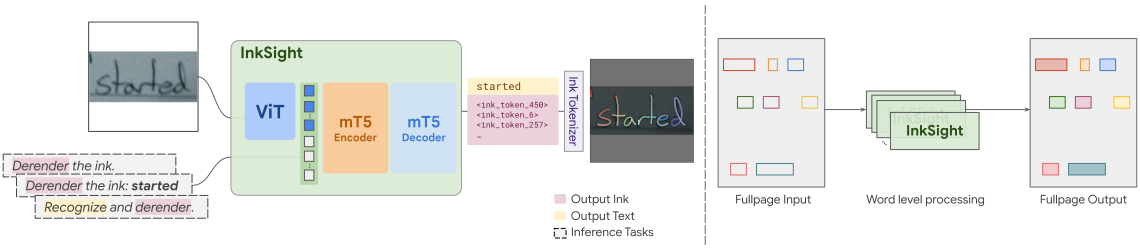

In [53]:
# @title # InkSight Overview
show_system()

# Visualize the generated Digital Ink (Pre-saved Model Outputs)

We provide the pre-saved model outputs from three variants (**Small-i**, **Small-p**, **Large-i**) of our models as described in the paper with the three inference modes corresponding to each column below (Derender with Text, Recognize and Derender, Vanilla Derender)

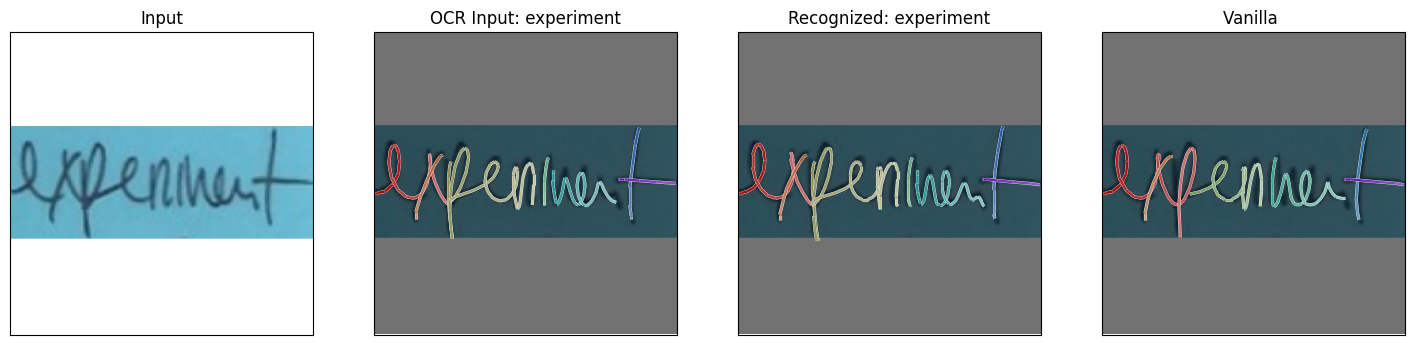

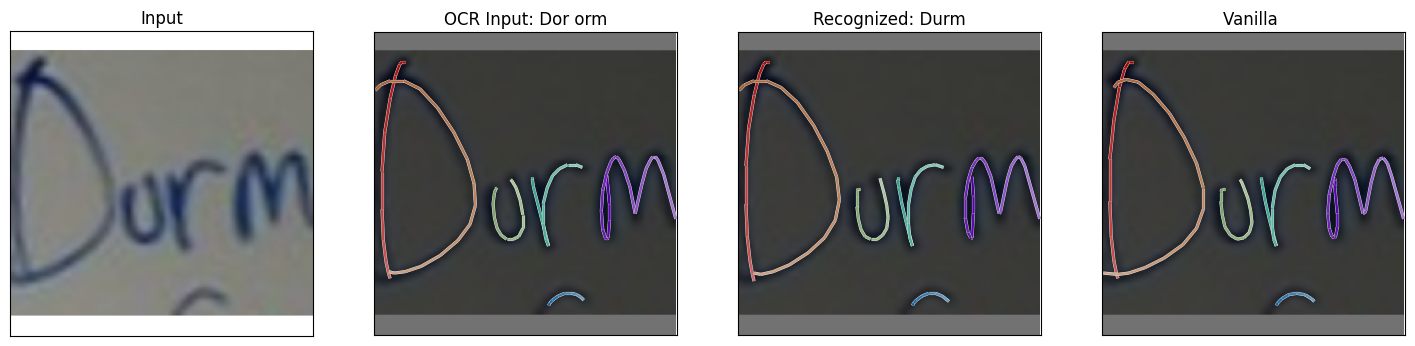

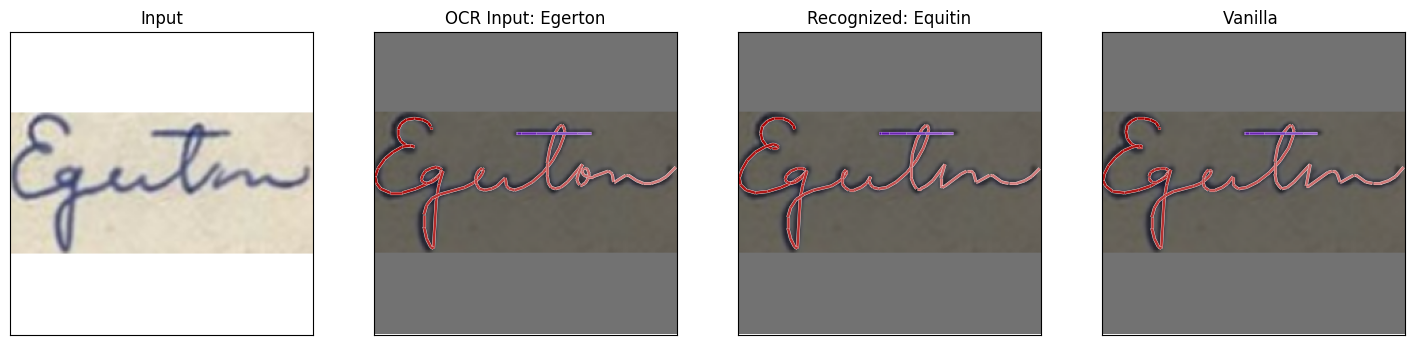

In [54]:
# @title Comparison between Inference Tasks
Dataset = "HierText" # @param ["IMGUR5K", "IAM", "HierText"]
Num_samples = 3 # @param {type:"integer"}
Model = "Small-i" # @param ["Small-i", "Large-i", "Small-p"]
inkml_path = None
if Model == "Small-i":
    inkml_path = f"./derendering_supp/small-i_{Dataset}_inkml"
elif Model == "Small-p":
    inkml_path = f"./derendering_supp/small-p_{Dataset}_inkml"
elif Model == "Large-i":
    inkml_path = f"./derendering_supp/large-i_{Dataset}_inkml"
else:
    raise ValueError('Now only supports Small-i, Small-p, Large-i.')
path = f"./derendering_supp/{Dataset}/images_sample"
samples = os.listdir(path)
picked_samples = random.sample(samples, Num_samples)

plot_title = {
    "r+d": "Recognized: ",
    "d+t": "OCR Input: ",
    "vanilla": "Vanilla"
}
query_modes = ["d+t", "r+d", "vanilla"]

for name in picked_samples:
    fig, ax = plt.subplots(1, 1+len(query_modes), figsize=(6*len(query_modes), 4))
    img = load_and_pad_img_dir(os.path.join(path, name))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].imshow(img)
    ax[0].set_title('Input')
    for i, mode in enumerate(query_modes):
        example_id = name.strip('.png')
        inkml_file = os.path.join(inkml_path, mode, example_id + '.inkml')
        ink = inkml_to_ink(inkml_file)
        text_field = parse_inkml_annotations(inkml_file)['textField']

        plot_ink(ink, ax[1+i], input_image=img, lw=1.8)
        ax[1+i].set_xticks([])
        ax[1+i].set_yticks([])
        ax[1+i].set_title(f'{plot_title[mode]}{text_field}')

    plt.show()

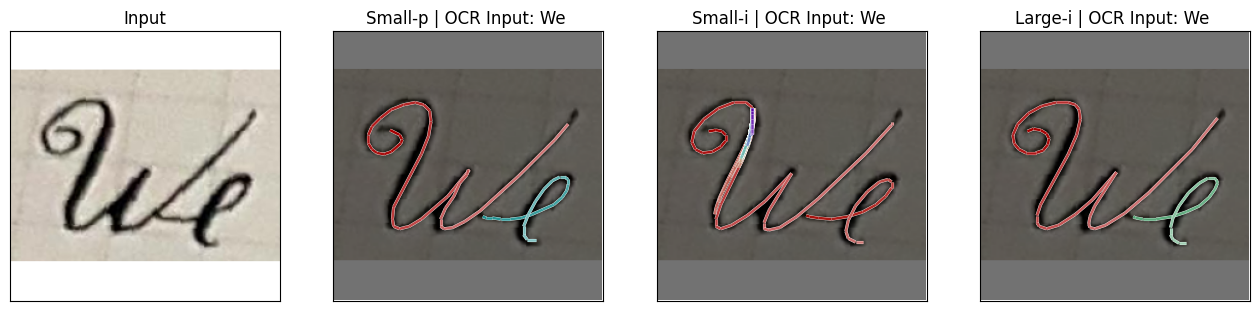

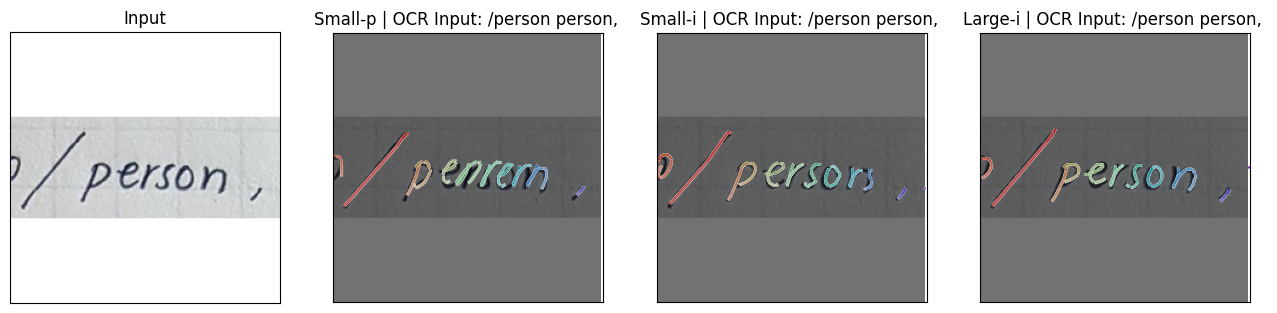

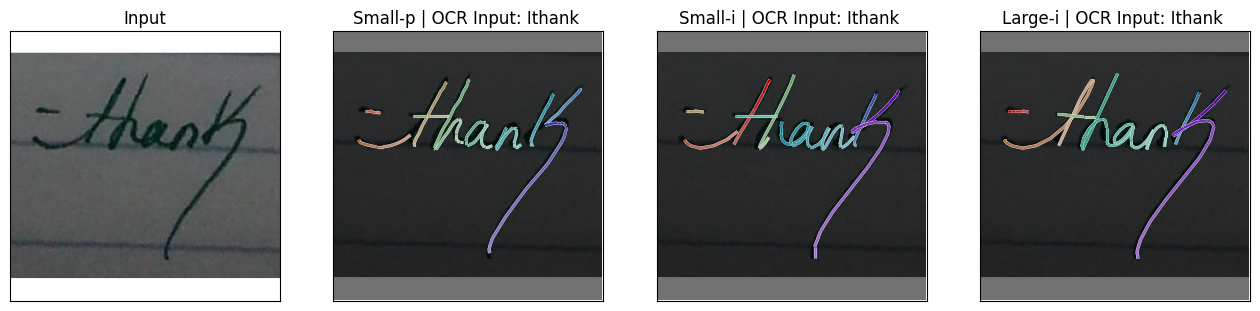

In [ ]:
# @title Comparison between Models using Derendering with Text
Dataset = "IMGUR5K" # @param ["IMGUR5K", "IAM", "HierText"]
Num_samples = 3 # @param {type:"integer"}
model_selections = ["Small-p", "Small-i", "Large-i"]

path = f"./derendering_supp/{Dataset}/images_sample"
samples = os.listdir(path)
picked_samples = random.sample(samples, Num_samples)
mode = 'd+t'

for name in picked_samples:
    fig, ax = plt.subplots(1, 1+len(query_modes), figsize=(4*(1+len(query_modes)), 4))
    img = load_and_pad_img_dir(os.path.join(path, name))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].imshow(img)
    ax[0].set_title('Input')
    for i, model in enumerate(model_selections):
        example_id = name.strip('.png')
        inkml_path = f"./derendering_supp/{model.lower()}_{Dataset}_inkml"
        inkml_file = os.path.join(inkml_path, mode, example_id + '.inkml')
        ink = inkml_to_ink(inkml_file)
        text_field = parse_inkml_annotations(inkml_file)['textField']

        plot_ink(ink, ax[1+i], input_image=img, lw=1.8)
        ax[1+i].set_xticks([])
        ax[1+i].set_yticks([])
        ax[1+i].set_title( model + " | OCR Input: " + text_field + ' ')

    plt.show()

## Compare with "Golden" Human Traced Data on HierText

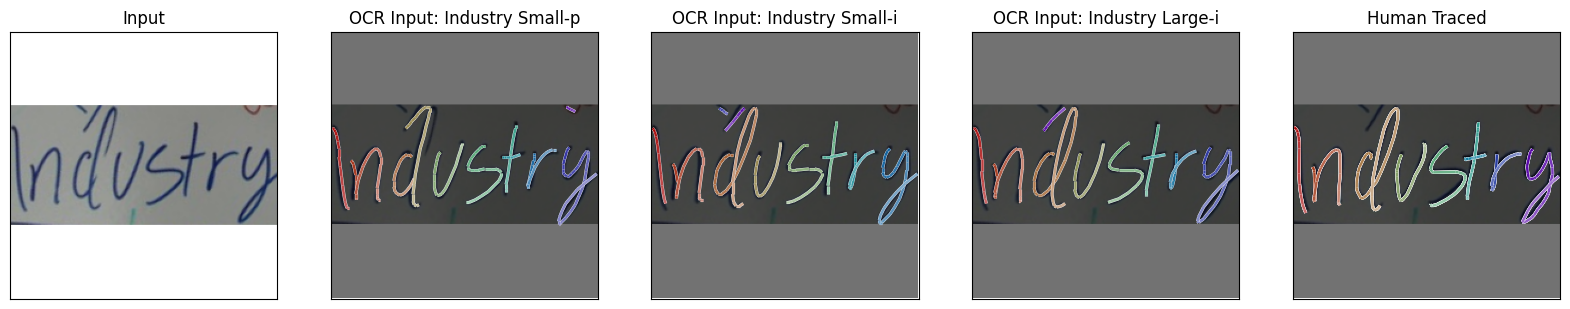

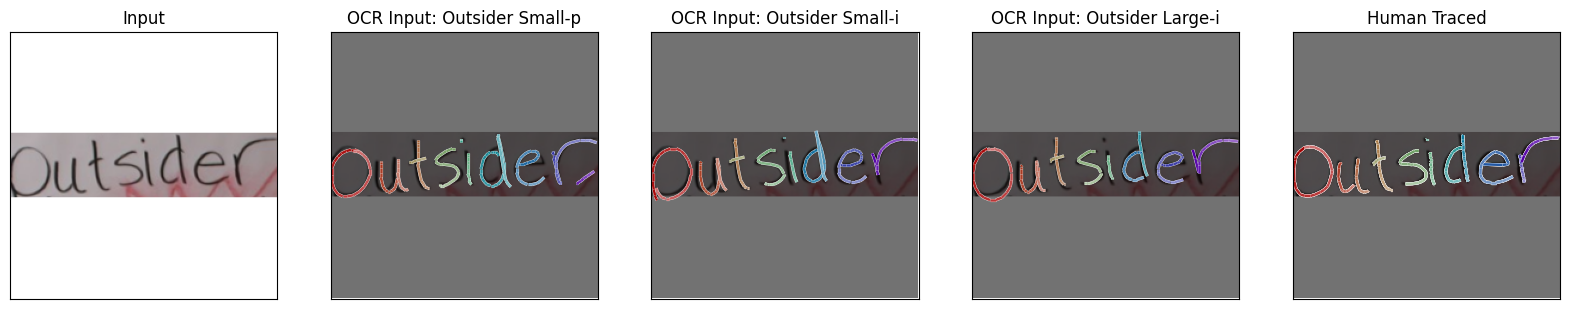

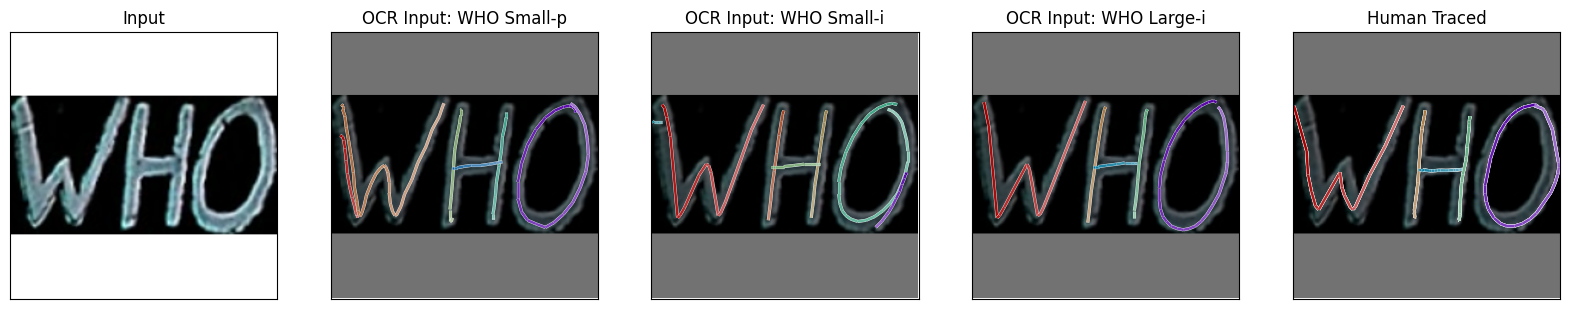

In [ ]:
human_ink = np.load('derendering_supp/human_tracing_hash_to_ink.npy', allow_pickle=True).item()
all_samples = human_ink.keys()

Dataset = "HierText"
Num_samples = 3 # @param {type:"integer"}
model_selections = ["Small-p", "Small-i", "Large-i"]

path = f"./derendering_supp/{Dataset}/images_sample"
samples = os.listdir(path)
picked_samples = random.sample(all_samples, Num_samples)
mode = 'd+t'

for name in picked_samples:
    fig, ax = plt.subplots(1, 1+len(query_modes)+1, figsize=(4*(1+len(query_modes)+1), 4))
    img = load_and_pad_img_dir(os.path.join(path, name + '.png'))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].imshow(img)
    ax[0].set_title('Input')
    for i, model in enumerate(model_selections):
        example_id = name.strip('.png')
        inkml_path = f"./derendering_supp/{model.lower()}_{Dataset}_inkml"
        inkml_file = os.path.join(inkml_path, mode, example_id + '.inkml')
        ink = inkml_to_ink(inkml_file)
        text_field = parse_inkml_annotations(inkml_file)['textField']

        plot_ink(ink, ax[1+i], input_image=img, lw=1.8)
        ax[1+i].set_xticks([])
        ax[1+i].set_yticks([])
        ax[1+i].set_title("OCR Input: " + text_field + ' ' + model)
        plot_ink(human_ink[example_id], ax[-1], input_image=img)
        ax[-1].set_xticks([])
        ax[-1].set_yticks([])
        ax[-1].set_title('Human Traced')

In [ ]:
# @title #### Visualize as gif, this might take a while
plot_ink_to_gif(ink, 'test.gif', input_image=img)

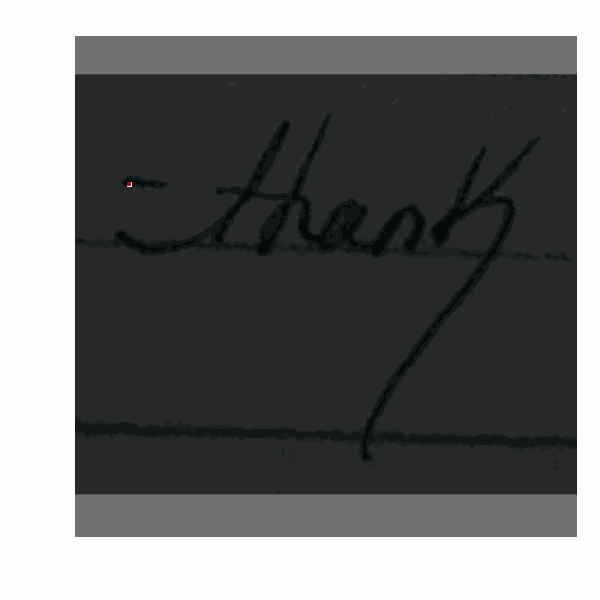

In [ ]:
IPython.display.Image('test.gif')

# Interactive Model Output Playground

In this section, we provide an interactive playground for model output using the Gradio interface. Please run the following cells and click on the generated Gradio link (e.g. `https://18379c03233d79b9c4.gradio.live` in the "gradio demo" cell) to proceed.

In [55]:
# @title Install gradio
!pip install -q gradio

In [56]:
# @title utils
import gradio as gr
import os
import random
import datetime
from pathlib import Path
import gdown
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from xml.dom import minidom
import os
import matplotlib.animation as animation
import copy
from PIL import ImageEnhance, Image, ImageDraw
import colorsys
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
from matplotlib.patheffects import withStroke
import random
import warnings
from matplotlib.figure import Figure
from io import BytesIO
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter
import requests
import zipfile
import base64


warnings.filterwarnings("ignore")


def get_svg_content(svg_path):
    with open(svg_path, "r") as file:
        return file.read()


def download_file(url, filename):
    response = requests.get(url)
    with open(filename, "wb") as f:
        f.write(response.content)


def unzip_file(filename, extract_to="."):
    with zipfile.ZipFile(filename, "r") as zip_ref:
        zip_ref.extractall(extract_to)


def get_base64_encoded_gif(gif_path):
    with open(gif_path, "rb") as gif_file:
        return base64.b64encode(gif_file.read()).decode("utf-8")


def load_and_pad_img_dir(file_dir):
    image_path = os.path.join(file_dir)
    image = Image.open(image_path)
    width, height = image.size
    ratio = min(224 / width, 224 / height)
    image = image.resize((int(width * ratio), int(height * ratio)))
    width, height = image.size
    if height < 224:
        # If width is shorter than height pad top and bottom.
        top_padding = (224 - height) // 2
        bottom_padding = 224 - height - top_padding
        padded_image = Image.new("RGB", (width, 224), (255, 255, 255))
        padded_image.paste(image, (0, top_padding))
    else:
        # Otherwise pad left and right.
        left_padding = (224 - width) // 2
        right_padding = 224 - width - left_padding
        padded_image = Image.new("RGB", (224, height), (255, 255, 255))
        padded_image.paste(image, (left_padding, 0))
    return padded_image


def plot_ink(ink, ax, lw=1.8, input_image=None, with_path=True, path_color="white"):
    if input_image is not None:
        img = copy.deepcopy(input_image)
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(0.45)
        ax.imshow(img)

    base_colors = plt.cm.get_cmap("rainbow", len(ink.strokes))

    for i, stroke in enumerate(ink.strokes):
        x, y = np.array(stroke.x), np.array(stroke.y)

        base_color = base_colors(len(ink.strokes) - 1 - i)
        hsv_color = colorsys.rgb_to_hsv(*base_color[:3])

        darker_color = colorsys.hsv_to_rgb(
            hsv_color[0], hsv_color[1], max(0, hsv_color[2] * 0.65)
        )
        colors = [
            mcolors.to_rgba(darker_color, alpha=1 - (0.5 * j / len(x)))
            for j in range(len(x))
        ]

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = LineCollection(segments, colors=colors, linewidth=lw)
        if with_path:
            lc.set_path_effects(
                [withStroke(linewidth=lw * 1.25, foreground=path_color)]
            )
        ax.add_collection(lc)

    ax.set_xlim(0, 224)
    ax.set_ylim(0, 224)
    ax.invert_yaxis()


def plot_ink_to_video(
    ink, output_name, lw=1.8, input_image=None, path_color="white", fps=30
):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

    if input_image is not None:
        img = copy.deepcopy(input_image)
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(0.45)
        ax.imshow(img)

    ax.set_xlim(0, 224)
    ax.set_ylim(0, 224)
    ax.invert_yaxis()
    ax.axis("off")

    base_colors = plt.cm.get_cmap("rainbow", len(ink.strokes))
    all_points = sum([len(stroke.x) for stroke in ink.strokes], 0)

    def update(frame):
        ax.clear()
        if input_image is not None:
            ax.imshow(img)
        ax.set_xlim(0, 224)
        ax.set_ylim(0, 224)
        ax.invert_yaxis()
        ax.axis("off")

        points_drawn = 0
        for stroke_index, stroke in enumerate(ink.strokes):
            x, y = np.array(stroke.x), np.array(stroke.y)
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            base_color = base_colors(len(ink.strokes) - 1 - stroke_index)
            hsv_color = colorsys.rgb_to_hsv(*base_color[:3])
            darker_color = colorsys.hsv_to_rgb(
                hsv_color[0], hsv_color[1], max(0, hsv_color[2] * 0.65)
            )
            visible_segments = (
                segments[: frame - points_drawn]
                if frame - points_drawn < len(segments)
                else segments
            )
            colors = [
                mcolors.to_rgba(
                    darker_color, alpha=1 - (0.5 * j / len(visible_segments))
                )
                for j in range(len(visible_segments))
            ]

            if len(visible_segments) > 0:
                lc = LineCollection(visible_segments, colors=colors, linewidth=lw)
                lc.set_path_effects(
                    [withStroke(linewidth=lw * 1.25, foreground=path_color)]
                )
                ax.add_collection(lc)

            points_drawn += len(segments)
            if points_drawn >= frame:
                break

    ani = FuncAnimation(fig, update, frames=all_points + 1, blit=False)
    Writer = FFMpegWriter(fps=fps)
    plt.tight_layout()
    ani.save(output_name, writer=Writer)
    plt.close(fig)


class Stroke:
    def __init__(self, list_of_coordinates=None) -> None:
        self.x = []
        self.y = []
        if list_of_coordinates:
            for point in list_of_coordinates:
                self.x.append(point[0])
                self.y.append(point[1])

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return (self.x[index], self.y[index])


class Ink:
    def __init__(self, list_of_strokes=None) -> None:
        self.strokes = []
        if list_of_strokes:
            self.strokes = list_of_strokes

    def __len__(self):
        return len(self.strokes)

    def __getitem__(self, index):
        return self.strokes[index]


def inkml_to_ink(inkml_file):
    """Convert inkml file to Ink"""
    tree = ET.parse(inkml_file)
    root = tree.getroot()

    inkml_namespace = {"inkml": "http://www.w3.org/2003/InkML"}

    strokes = []

    for trace in root.findall("inkml:trace", inkml_namespace):
        points = trace.text.strip().split()
        stroke_points = []

        for point in points:
            x, y = point.split(",")
            stroke_points.append((float(x), float(y)))
        strokes.append(Stroke(stroke_points))
    return Ink(strokes)


def parse_inkml_annotations(inkml_file):
    tree = ET.parse(inkml_file)
    root = tree.getroot()

    annotations = root.findall(".//{http://www.w3.org/2003/InkML}annotation")

    annotation_dict = {}

    for annotation in annotations:
        annotation_type = annotation.get("type")
        annotation_text = annotation.text

        annotation_dict[annotation_type] = annotation_text

    return annotation_dict


def pregenerate_videos(video_cache_dir):
    datasets = ["IAM", "IMGUR5K", "HierText"]
    models = ["Small-i", "Large-i", "Small-p"]
    query_modes = ["d+t", "r+d", "vanilla"]
    for Dataset in datasets:
        for Model in models:
            inkml_path_base = f"./derendering_supp/{Model.lower()}_{Dataset}_inkml"
            for mode in query_modes:
                path = f"./derendering_supp/{Dataset}/images_sample"
                if not os.path.exists(path):
                    continue
                samples = os.listdir(path)
                for name in tqdm(
                    samples, desc=f"Generating {Model}-{Dataset}-{mode} videos"
                ):
                    example_id = name.strip(".png")
                    inkml_file = os.path.join(
                        inkml_path_base, mode, f"{example_id}.inkml"
                    )
                    if not os.path.exists(inkml_file):
                        continue
                    video_filename = f"{Model}_{Dataset}_{mode}_{example_id}.mp4"
                    video_filepath = video_cache_dir / video_filename
                    if not video_filepath.exists():
                        img_path = os.path.join(path, name)
                        img = load_and_pad_img_dir(img_path)
                        ink = inkml_to_ink(inkml_file)
                        plot_ink_to_video(ink, str(video_filepath), input_image=img)



In [ ]:
# @title gradio playground
pre_generate = False

file_url = "https://storage.googleapis.com/derendering_model/derendering_supp.zip"
filename = "derendering_supp.zip"

# Cache videos to speed up demo
video_cache_dir = Path("./cached_videos")
video_cache_dir.mkdir(exist_ok=True)

download_file(file_url, filename)
unzip_file(filename)
print("Downloaded and unzipped the inks.")

if not pre_generate:
    print("Downloading pre-generated videos from google drive.")
    # Download from gdown 1oT6zw1EbWg3lavBMXsL28piULGNmqJzA
    gdown.download(
        "https://drive.google.com/uc?id=1oT6zw1EbWg3lavBMXsL28piULGNmqJzA",
        str(video_cache_dir / "gdrive_file.zip"),
        quiet=False,
    )

    # Unzip the file to video_cache_dir
    unzip_file(str(video_cache_dir / "gdrive_file.zip"))
else:
    pregenerate_videos(video_cache_dir=video_cache_dir)
    print("Videos cached.")


def demo(Dataset, Model):
    if Model == "Small-i":
        inkml_path = f"./derendering_supp/small-i_{Dataset}_inkml"
    elif Model == "Small-p":
        inkml_path = f"./derendering_supp/small-p_{Dataset}_inkml"
    elif Model == "Large-i":
        inkml_path = f"./derendering_supp/large-i_{Dataset}_inkml"

    now = datetime.datetime.now()
    random.seed(now.timestamp())
    now = now.strftime("%Y-%m-%d %H:%M:%S")
    print(
        now,
        "Taking sample from dataset:",
        Dataset,
        "and model:",
        Model,
    )
    path = f"./derendering_supp/{Dataset}/images_sample"
    samples = os.listdir(path)
    # Randomly pick a sample
    picked_samples = random.sample(samples, min(1, len(samples)))

    query_modes = ["d+t", "r+d", "vanilla"]
    plot_title = {"r+d": "Recognized: ", "d+t": "OCR Input: ", "vanilla": ""}
    text_outputs = []
    # img_outputs = []
    video_outputs = []
    for name in picked_samples:
        img_path = os.path.join(path, name)
        img = load_and_pad_img_dir(img_path)

        for mode in query_modes:
            example_id = name.strip(".png")
            inkml_file = os.path.join(inkml_path, mode, example_id + ".inkml")
            text_field = parse_inkml_annotations(inkml_file)["textField"]
            output_text = f"{plot_title[mode]}{text_field}"
            text_outputs.append(output_text)
            ink = inkml_to_ink(inkml_file)

            video_filename = f"{Model}_{Dataset}_{mode}_{example_id}.mp4"
            video_filepath = video_cache_dir / video_filename

            if not video_filepath.exists():
                plot_ink_to_video(ink, str(video_filepath), input_image=img)
                print("Cached video at:", video_filepath)
            video_outputs.append("./" + str(video_filepath))

    return (
        img,
        text_outputs[0],
        video_outputs[0],
        text_outputs[1],
        video_outputs[1],
        text_outputs[2],
        video_outputs[2],
    )


with gr.Blocks() as app:
    gr.Markdown(
        "# InkSight: Offline-to-Online Handwriting Conversion by Learning to Read and Write"
    )
    gr.Markdown(
        """
        🚀 This demo highlights the capabilities of Small-i, Small-p, and Large-i across three public datasets (word-level, with 100 random samples each).<br>
        🎲 Select a model variant and dataset (IAM, IMGUR5K, HierText), then hit 'Sample' to view a randomly selected input alongside its corresponding outputs for all three types of inference.<br>
        """
    )
    with gr.Row():
        dataset = gr.Dropdown(
            ["IAM", "IMGUR5K", "HierText"], label="Dataset", value="IAM"
        )
        model = gr.Dropdown(
            ["Small-i", "Large-i", "Small-p"],
            label="InkSight Model Variant",
            value="Small-i",
        )
        im = gr.Image(label="Input Image")


    with gr.Row():
        d_t_text = gr.Textbox(
            label="OCR recognition input to the model", interactive=False
        )
        r_d_text = gr.Textbox(label="Recognition from the model", interactive=False)
        vanilla_text = gr.Textbox(label="Vanilla", interactive=False)
    with gr.Row():
        d_t_vid = gr.Video(
            label="Derender with Text (Click to stop/play)", autoplay=True
        )
        r_d_vid = gr.Video(
            label="Recognize and Derender (Click to stop/play)", autoplay=True
        )
        vanilla_vid = gr.Video(label="Vanilla (Click to stop/play)", autoplay=True)

    with gr.Row():
        btn_sub = gr.Button("Sample")

    btn_sub.click(
        fn=demo,
        inputs=[dataset, model],
        outputs=[
            im,
            d_t_text,
            d_t_vid,
            r_d_text,
            r_d_vid,
            vanilla_text,
            vanilla_vid,
        ],
    )

app.launch()

Downloaded and unzipped the inks.


Downloading...
From (original): https://drive.google.com/uc?id=1oT6zw1EbWg3lavBMXsL28piULGNmqJzA
From (redirected): https://drive.google.com/uc?id=1oT6zw1EbWg3lavBMXsL28piULGNmqJzA&confirm=t&uuid=07cbc45b-a42d-445f-b041-be180fa805f6
To: /content/cached_videos/gdrive_file.zip
100%|██████████| 201M/201M [00:05<00:00, 34.5MB/s]


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://18379c03233d79b9c4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Inference with the Public Small-p Model

This section demonstrates inference examples using the Small-p model from our paper, both with the fullpage InkSight pipeline (with open source Tesseract OCR) and at the word-level.


In [ ]:
# @title Notice
display(HTML('<p style="font-size:20px; font-weight:bold; color:red; background-color:lightgray; padding:10px; width:50%">Notice on Model Release</p>'))
display(HTML('<p style="font-size:16px; width:50%">Model download will be available once the release process is complete. For optimal performance, please use a T4 GPU runtime in colab. </p>'))


In [ ]:
# @title Dependencies
!pip install -q tensorflow==2.15.0
!pip install -q tensorflow-text==2.15.0
!sudo apt -qq install tesseract-ocr
!pip install pytesseract

In [57]:
# @title Utils
import tensorflow as tf
import tensorflow_text
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from xml.dom import minidom
import gdown
import os
import matplotlib.animation as animation
import copy
from PIL import ImageEnhance, Image, ImageDraw
import colorsys
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
from matplotlib.patheffects import withStroke
import random
import warnings
import re
import time
import io
import pytesseract
from tqdm import tqdm
from copy import deepcopy


def get_box(data_idx, data):
    min_x = left = data['left'][data_idx]
    min_y = top = data['top'][data_idx]
    width = data['width'][data_idx]
    angle = 0
    height = data['height'][data_idx]
    angle = angle / 180.0 * np.pi
    s_x = left + np.cos(angle) * width
    s_y = top - np.sin(angle) * width
    f_x = (
        left + np.sin(angle) * height
    )
    f_y = top + np.cos(angle) * height
    max_x = (
        left
        + np.cos(angle) * width
        + np.sin(angle) * height
    )
    max_y = (
        top
        - np.sin(angle) * width
        + np.cos(angle) * height
    )
    return min_x, min_y, s_x, s_y, f_x, f_y, max_x, max_y

def rotate_crop_scale_and_pad(original, data_idx, data, pad_black=True):
    angle = 0
    height = data['height'][data_idx]
    width = data['width'][data_idx]
    min_x, min_y, s_x, s_y, f_x, f_y, _, _ = get_box(data_idx, data)
    max_x = min_x + width
    max_y = min_y + height

    output = original.rotate(angle, center=(min_x, min_y))
    crop = output.crop((min_x, min_y, max_x, max_y))

    ratio = min(224 / crop.width, 224 / crop.height)
    new_crop = crop.resize((int(crop.width * ratio), int(crop.height * ratio)))
    new_crop_np = np.array(new_crop)

    pixel_1 = new_crop_np[1, 1]
    pixel_2 = new_crop_np[1, new_crop_np.shape[-1] - 1]
    pixel_3 = new_crop_np[new_crop_np.shape[0] - 1, 1]
    pixel_4 = new_crop_np[new_crop_np.shape[0] - 1, new_crop_np.shape[-1] - 1]
    avg = np.rint(np.mean([pixel_1, pixel_2, pixel_3, pixel_4], axis=0)).astype(
        np.uint8
    )

    color = tuple(avg) if not pad_black else (0, 0, 0)
    new_image = Image.new(new_crop.mode, (224, 224), color)
    dx = (224 - new_crop.width) // 2
    dy = (224 - new_crop.height) // 2
    new_image.paste(new_crop, (dx, dy))
    return new_image, ratio, dx, dy, min_x, min_y, angle, crop


def extract_fullpage(input_image):
    ret_imgs = []
    img_info = []
    img_bbox = []
    data = pytesseract.image_to_data(input_image, output_type=pytesseract.Output.DICT)
    for i in tqdm(range(len(data['text']))):
        if data['text'][i].strip() != '':  # Filters out empty text results
            new_image, ratio, dx, dy, min_x, min_y, angle, _ = (
                rotate_crop_scale_and_pad(input_image, i, data, pad_black=True)
            )
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            ret_imgs.append(new_image)
            img_info.append((ratio, dx, dy, min_x, min_y, angle))
            img_bbox.append((x, y, w, h))
    print('\nFinal length: ', len(ret_imgs))

    # Draw the bboxes
    image = deepcopy(input_image)
    draw = ImageDraw.Draw(image)
    for bx in img_bbox:
        x, y, w, h = bx
        draw.rectangle([x, y, x + w, y + h], outline='red', width=2)

    return ret_imgs, img_info, image


warnings.filterwarnings("ignore")

def text_to_tokens(text) -> list[int]:
    pattern = r"<ink_token_(\d+)>"
    matches = re.findall(pattern, text)
    return [int(tok) for tok in matches]

def detokenize(tokens: list[int]) -> list[list[tuple[float, float]]]:
    coordinate_length = 224
    num_token_per_dimension = coordinate_length + 1
    vocabulary_size = num_token_per_dimension * 2 + 1
    start_token = num_token_per_dimension * 2

    if any([t < 0 or t >= vocabulary_size for t in tokens]):
        raise ValueError(
            f"Ink token indices should be between 0 and {vocabulary_size}"
        )
    idx = 0
    res = []
    current_stroke_tokens = []

    while idx < len(tokens):
        token = tokens[idx]
        if token == start_token:
            if current_stroke_tokens:
                res.append(current_stroke_tokens)
            current_stroke_tokens = []
            idx += 1
        else:
            if idx + 1 < len(tokens) and (tokens[idx + 1] != start_token):
                # Read in x and y coordinates.
                x = tokens[idx]
                y = tokens[idx + 1] - num_token_per_dimension
                # If the coordinates are valid, add them to detokenization ink.
                if (0 <= x <= coordinate_length) and (0 <= y <= coordinate_length):
                    current_stroke_tokens.append([x, y])
                idx += 2
            # If y doesn't exist or y is start_token, then skip this x.
            else:
                idx += 1
    if current_stroke_tokens:
        res.append(current_stroke_tokens)

    strokes = []
    for stroke in res:
        stroke_points = []
        for point in stroke:
            x, y = point
            stroke_points.append((x, y))
        strokes.append(Stroke(stroke_points))
    return Ink(strokes)

def load_and_pad_img(image):
    width, height = image.size
    ratio = min(224 / width, 224 / height)
    image = image.resize((int(width * ratio), int(height * ratio)))
    width, height = image.size
    if height < 224:
        # If width is shorter than height pad top and bottom.
        top_padding = (224 - height) // 2
        bottom_padding = 224 - height - top_padding
        padded_image = Image.new('RGB', (width, 224), (255, 255, 255))
        padded_image.paste(image, (0, top_padding))
    else:
        # Otherwise pad left and right.
        left_padding = (224 - width) // 2
        right_padding = 224 - width - left_padding
        padded_image = Image.new('RGB', (224, height), (255, 255, 255))
        padded_image.paste(image, (left_padding, 0))
    return padded_image

def scale_and_pad(original, pad_black=True):
    ratio = min(224 / original.width, 224 / original.height)
    original_np = np.array(original)
    new_crop = original.resize((int(original.width * ratio), int(original.height * ratio)))
    pixel_1 = original_np[1, 1]
    pixel_2 = original_np[1, original_np.shape[-1]-1]
    pixel_3 = original_np[original_np.shape[0]-1, 1]
    pixel_4 = original_np[original_np.shape[0]-1, original_np.shape[-1]-1]
    avg = np.rint(np.mean([pixel_1, pixel_2, pixel_3, pixel_4], axis=0)).astype(np.uint8)

    color = tuple(avg) if not pad_black else (0, 0, 0)
    new_image = Image.new(new_crop.mode, (224, 224), color)
    dx = (224 - new_crop.width) // 2
    dy = (224 - new_crop.height) // 2
    new_image.paste(new_crop, (dx, dy))
    return new_image, ratio, dx, dy, new_crop

def encode_images_in_batches(images, batch_size=32):
    def encode_image(image):
        image_np = np.array(image)[:, :, :3]
        encoded_jpeg = tf.io.encode_jpeg(image_np)
        return tf.reshape(encoded_jpeg, (1,)), image_np

    encoded_batches = []
    original_batches = []

    num_batches = len(images) // batch_size + (1 if len(images) % batch_size != 0 else 0)

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(images))
        current_batch = images[start_idx:end_idx]

        encoded_batch = []
        original_batch = []
        for image in current_batch:
            encoded, original = encode_image(image)
            encoded_batch.append(encoded)
            original_batch.append(original)

        encoded_batches.append(tf.stack(encoded_batch))
        original_batches.append(np.stack(original_batch))

    return encoded_batches, original_batches

def unpad_unscale_unrotate_uncrop(ink, ratio, dx, dy, min_x, min_y, angle):
    transformed_strokes = []

    for stroke in ink:
        transformed_points = []
        for point in stroke:
            x_transformed = (point[0] - dx) / ratio
            y_transformed = (point[1] - dy) / ratio

            x_final = x_transformed + min_x
            y_final = y_transformed + min_y

            transformed_points.append((x_final, y_final))

        transformed_strokes.append(Stroke(transformed_points))

    transformed_ink = Ink(transformed_strokes)
    return transformed_ink

In [58]:
# @title Download from link or use hugging face model

# !wget https://storage.googleapis.com/derendering_model/small-p-cpu.zip
# !unzip small-p-cpu.zip
# model = tf.saved_model.load('small-p-cpu')

from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras("Derendering/InkSight-Small-p")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

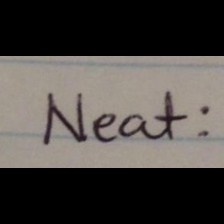

In [64]:
# @title Word level Inference

# try:
#     from google.colab import files
#     in_colab = True
# except ImportError:
#     in_colab = False

# if in_colab:
#     uploaded = files.upload()
#     input_image = Image.open(io.BytesIO(uploaded[list(uploaded.keys())[0]]))
# else:
#     file_path = 'test_inputs/word.jpg'
#     input_image = Image.open(file_path)

file_path = 'input/word.jpg'
input_image = Image.open(file_path)

image, _, _, _, _ = scale_and_pad(input_image)

image

In [65]:
# @title Word-level inference
cf = model.signatures['serving_default']
input_text = tf.constant(["Recognize and derender."], dtype=tf.string)
image_encoded = tf.reshape(tf.io.encode_jpeg(np.array(image)[:, :, :3]), (1, 1))
output = cf(**{'input_text': input_text, 'image/encoded': image_encoded})

In [66]:
output

{'output_1': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>,
 'output_0': <tf.Tensor: shape=(1, 1), dtype=string, numpy=
 array([[b'<extra_id_0> Neat: <ink_token_450> <ink_token_1> <ink_token_290> <ink_token_450> <ink_token_50> <ink_token_320> <ink_token_50> <ink_token_321> <ink_token_50> <ink_token_322> <ink_token_50> <ink_token_324> <ink_token_50> <ink_token_327> <ink_token_50> <ink_token_330> <ink_token_50> <ink_token_334> <ink_token_50> <ink_token_338> <ink_token_50> <ink_token_343> <ink_token_49> <ink_token_348> <ink_token_49> <ink_token_353> <ink_token_48> <ink_token_358> <ink_token_47> <ink_token_362> <ink_token_47> <ink_token_365> <ink_token_46> <ink_token_367> <ink_token_46> <ink_token_368> <ink_token_46> <ink_token_367> <ink_token_450> <ink_token_50> <ink_token_330> <ink_token_51> <ink_token_330> <ink_token_52> <ink_token_331> <ink_token_54> <ink_token_333> <ink_token_56> <ink_token_335> <ink_token_58> <ink_token_338> <ink_token_61> <ink_token_34

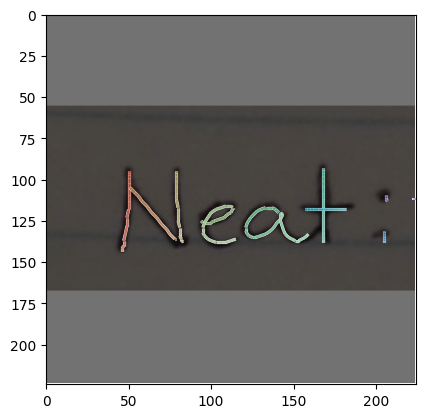

In [67]:
# @title Result Visualization
output_ink = detokenize(text_to_tokens(output['output_0'].numpy()[0][0].decode()))
fig, ax = plt.subplots()
plot_ink(output_ink, ax, input_image=load_and_pad_img(input_image))
plt.show()

In [ ]:
# @title Full page pipeline with Tesseract
try:
    from google.colab import files
    in_colab = True
except ImportError:
    in_colab = False

if in_colab:
    uploaded = files.upload()
    input_image = Image.open(io.BytesIO(uploaded[list(uploaded.keys())[0]]))
else:
    file_path = 'test_inputs/page.jpg'
    input_image = Image.open(file_path)

Saving iShot_2024-05-22_15.46.19.jpg to iShot_2024-05-22_15.46.19.jpg


100%|██████████| 13/13 [00:00<00:00, 835.24it/s]


Final length:  9


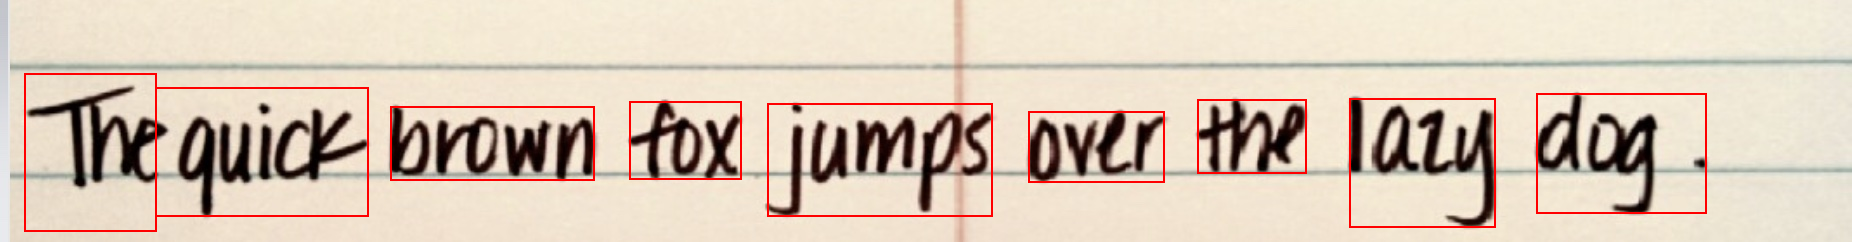

In [ ]:
# @title Tesseract
word_imgs, word_info, bbox_img = extract_fullpage(input_image)
bbox_img

In [ ]:
# @title Full Page Batch Inference
batchsize=32
output_inks=[]
cf = model.signatures['serving_default']
input_text = tf.constant(["Recognize and derender."], dtype=tf.string)
encode_word_imgs, original_word_imgs = encode_images_in_batches(word_imgs, batch_size=batchsize)
output_batches = []
t1 = time.perf_counter()
for batch_img in tqdm(encode_word_imgs):
    num_imgs_in_batch = batch_img.shape[0]
    input_text = tf.constant(["Derender the ink."] * num_imgs_in_batch, dtype=tf.string)
    output = cf(**{'input_text': input_text, 'image/encoded': batch_img})
    output_batches.append(output)
    for idx in range(output_batches[-1]["output_0"].shape[0]):
        output_inks.append(detokenize(text_to_tokens(output_batches[-1]["output_0"].numpy()[idx][0].decode())))
t2 = time.perf_counter()

100%|██████████| 1/1 [00:45<00:00, 45.40s/it]


In [1]:
# @title Result Visualization
output_inks = []
for b_id in range(len(output_batches)):
    for i in range(output_batches[b_id]['output_0'].shape[0]):
        output = output_batches[b_id]['output_0'].numpy()[i][0].decode()
        # fig, ax = plt.subplots()
        output_ink = detokenize(text_to_tokens(output))
        output_inks.append(output_ink)
        # plot_ink(output_ink, ax, input_image=Image.fromarray(original_word_imgs[b_id][i]))
        # plt.show()

all_inks = []
for ink, (ratio, dx, dy, min_x, min_y, angle) in zip(output_inks, word_info):
    recover_ink = unpad_unscale_unrotate_uncrop(ink, ratio, dx, dy, min_x, min_y, angle)
    all_inks.append(recover_ink)

lw=1.3
path_color='white'

fig, ax = plt.subplots(3, 1, figsize=(20, 10))
img = copy.deepcopy(input_image)
ax[0].imshow(input_image)
ax[0].set_title('Input Full page image')
ax[1].imshow(bbox_img)
ax[1].set_title("Tesseract")
ax[2].set_title("InkSight Result (Public Small-p)")

enhancer = ImageEnhance.Brightness(img)
img = copy.deepcopy(input_image)
img = enhancer.enhance(0.45)
ax[2].imshow(img)
for ink in all_inks:
    base_colors = plt.cm.get_cmap('rainbow', len(ink.strokes))
    for i, stroke in enumerate(ink.strokes):
        x, y = np.array(stroke.x), np.array(stroke.y)

        base_color = base_colors(len(ink.strokes) - 1 - i)
        hsv_color = colorsys.rgb_to_hsv(*base_color[:3])

        darker_color = colorsys.hsv_to_rgb(hsv_color[0], hsv_color[1], max(0, hsv_color[2] * 0.65))
        colors = [mcolors.to_rgba(darker_color, alpha=1 - (0.5 * j / len(x))) for j in range(len(x))]

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = LineCollection(segments, colors=colors, linewidth=lw)
        lc_two = LineCollection(segments, colors=colors, linewidth=lw)
        lc.set_path_effects([withStroke(linewidth=lw*1.25, foreground=path_color)])
        lc_two.set_path_effects([withStroke(linewidth=lw*1.8)])
        ax[2].add_collection(lc)
        ax[1].add_collection(lc_two)

NameError: name 'output_batches' is not defined

In [ ]:
# @title Result Visualization
output_inks = []
for b_id in range(len(output_batches)):
    for i in range(output_batches[b_id]['output_0'].shape[0]):
        output = output_batches[b_id]['output_0'].numpy()[i][0].decode()
        # fig, ax = plt.subplots()
        output_ink = detokenize(text_to_tokens(output))
        output_inks.append(output_ink)
        # plot_ink(output_ink, ax, input_image=Image.fromarray(original_word_imgs[b_id][i]))
        # plt.show()

all_inks = []
for ink, (ratio, dx, dy, min_x, min_y, angle) in zip(output_inks, word_info):
    recover_ink = unpad_unscale_unrotate_uncrop(ink, ratio, dx, dy, min_x, min_y, angle)
    all_inks.append(recover_ink)

lw=1.3
path_color='white'

fig, ax = plt.subplots(3, 1, figsize=(20, 10))
img = copy.deepcopy(input_image)
ax[0].imshow(input_image)
ax[0].set_title('Input Full page image')
ax[1].imshow(bbox_img)
ax[1].set_title("Tesseract")
ax[2].set_title("InkSight Result (Public Small-p)")

enhancer = ImageEnhance.Brightness(img)
img = copy.deepcopy(input_image)
img = enhancer.enhance(0.45)
ax[2].imshow(img)
for ink in all_inks:
    base_colors = plt.cm.get_cmap('rainbow', len(ink.strokes))
    for i, stroke in enumerate(ink.strokes):
        x, y = np.array(stroke.x), np.array(stroke.y)

        base_color = base_colors(len(ink.strokes) - 1 - i)
        hsv_color = colorsys.rgb_to_hsv(*base_color[:3])

        darker_color = colorsys.hsv_to_rgb(hsv_color[0], hsv_color[1], max(0, hsv_color[2] * 0.65))
        colors = [mcolors.to_rgba(darker_color, alpha=1 - (0.5 * j / len(x))) for j in range(len(x))]

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = LineCollection(segments, colors=colors, linewidth=lw)
        lc_two = LineCollection(segments, colors=colors, linewidth=lw)
        lc.set_path_effects([withStroke(linewidth=lw*1.25, foreground=path_color)])
        lc_two.set_path_effects([withStroke(linewidth=lw*1.8)])
        ax[2].add_collection(lc)
        ax[1].add_collection(lc_two)

NameError: name 'output_batches' is not defined

In [ ]:
# @title Result Visualization
output_inks = []
for b_id in range(len(output_batches)):
    for i in range(output_batches[b_id]['output_0'].shape[0]):
        output = output_batches[b_id]['output_0'].numpy()[i][0].decode()
        # fig, ax = plt.subplots()
        output_ink = detokenize(text_to_tokens(output))
        output_inks.append(output_ink)
        # plot_ink(output_ink, ax, input_image=Image.fromarray(original_word_imgs[b_id][i]))
        # plt.show()

all_inks = []
for ink, (ratio, dx, dy, min_x, min_y, angle) in zip(output_inks, word_info):
    recover_ink = unpad_unscale_unrotate_uncrop(ink, ratio, dx, dy, min_x, min_y, angle)
    all_inks.append(recover_ink)

lw=1.3
path_color='white'

fig, ax = plt.subplots(3, 1, figsize=(20, 10))
img = copy.deepcopy(input_image)
ax[0].imshow(input_image)
ax[0].set_title('Input Full page image')
ax[1].imshow(bbox_img)
ax[1].set_title("Tesseract")
ax[2].set_title("InkSight Result (Public Small-p)")

enhancer = ImageEnhance.Brightness(img)
img = copy.deepcopy(input_image)
img = enhancer.enhance(0.45)
ax[2].imshow(img)
for ink in all_inks:
    base_colors = plt.cm.get_cmap('rainbow', len(ink.strokes))
    for i, stroke in enumerate(ink.strokes):
        x, y = np.array(stroke.x), np.array(stroke.y)

        base_color = base_colors(len(ink.strokes) - 1 - i)
        hsv_color = colorsys.rgb_to_hsv(*base_color[:3])

        darker_color = colorsys.hsv_to_rgb(hsv_color[0], hsv_color[1], max(0, hsv_color[2] * 0.65))
        colors = [mcolors.to_rgba(darker_color, alpha=1 - (0.5 * j / len(x))) for j in range(len(x))]

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = LineCollection(segments, colors=colors, linewidth=lw)
        lc_two = LineCollection(segments, colors=colors, linewidth=lw)
        lc.set_path_effects([withStroke(linewidth=lw*1.25, foreground=path_color)])
        lc_two.set_path_effects([withStroke(linewidth=lw*1.8)])
        ax[2].add_collection(lc)
        ax[1].add_collection(lc_two)

NameError: name 'output_batches' is not defined

In [1]:
from huggingface_hub import from_pretrained_keras
import tensorflow_text
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import re
import pytesseract
from tqdm import tqdm
from copy import deepcopy
from PIL import ImageEnhance, Image, ImageDraw
import time
import warnings

ModuleNotFoundError: No module named 'tensorflow_text'

In [15]:
!sudo apt -qq install tesseract-ocr

The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-eng_1%3a4.00~git30-7274cf

In [1]:
!pip install gdown==5.2.0
!pip install gradio==5.4.0
# !pip install ipython==8.12.3
!pip install matplotlib==3.9.2
!pip install numpy==1.23.5
!pip install Pillow==11.0.0
!pip install protobuf==4.23.2
!pip install pytesseract==0.3.13
!pip install Requests==2.32.3
!pip install tensorflow==2.15.0
!pip install tensorflow_text==2.15.0
!pip install tqdm==4.66.6


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.8 MB/s eta 0:00:00
  Attempting uninstall: ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      S

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 60.7 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Successfully uninstalled matplotlib-3.8.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 100.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
bigframes 1.25.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.87 requires numpy>=1.24.1, but you have numpy 1.23.5 which is inco

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully

In [3]:
from huggingface_hub import from_pretrained_keras
import tensorflow_text
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import re
import pytesseract
from tqdm import tqdm
from copy import deepcopy
from PIL import ImageEnhance, Image, ImageDraw
import time
import warnings

In [31]:


def get_box(data_idx, data):
    min_x = left = data['left'][data_idx]
    min_y = top = data['top'][data_idx]
    width = data['width'][data_idx]
    angle = 0
    height = data['height'][data_idx]
    angle = angle / 180.0 * np.pi
    s_x = left + np.cos(angle) * width
    s_y = top - np.sin(angle) * width
    f_x = (
        left + np.sin(angle) * height
    )
    f_y = top + np.cos(angle) * height
    max_x = (
        left
        + np.cos(angle) * width
        + np.sin(angle) * height
    )
    max_y = (
        top
        - np.sin(angle) * width
        + np.cos(angle) * height
    )
    return min_x, min_y, s_x, s_y, f_x, f_y, max_x, max_y

def rotate_crop_scale_and_pad(original, data_idx, data, pad_black=True):
    angle = 0
    height = data['height'][data_idx]
    width = data['width'][data_idx]
    min_x, min_y, s_x, s_y, f_x, f_y, _, _ = get_box(data_idx, data)
    max_x = min_x + width
    max_y = min_y + height

    output = original.rotate(angle, center=(min_x, min_y))
    crop = output.crop((min_x, min_y, max_x, max_y))

    ratio = min(224 / crop.width, 224 / crop.height)
    new_crop = crop.resize((int(crop.width * ratio), int(crop.height * ratio)))
    new_crop_np = np.array(new_crop)

    pixel_1 = new_crop_np[1, 1]
    pixel_2 = new_crop_np[1, new_crop_np.shape[-1] - 1]
    pixel_3 = new_crop_np[new_crop_np.shape[0] - 1, 1]
    pixel_4 = new_crop_np[new_crop_np.shape[0] - 1, new_crop_np.shape[-1] - 1]
    avg = np.rint(np.mean([pixel_1, pixel_2, pixel_3, pixel_4], axis=0)).astype(
        np.uint8
    )

    color = tuple(avg) if not pad_black else (0, 0, 0)
    new_image = Image.new(new_crop.mode, (224, 224), color)
    dx = (224 - new_crop.width) // 2
    dy = (224 - new_crop.height) // 2
    new_image.paste(new_crop, (dx, dy))
    return new_image, ratio, dx, dy, min_x, min_y, angle, crop


def extract_fullpage(input_image):
    ret_imgs = []
    img_info = []
    img_bbox = []
    data = pytesseract.image_to_data(input_image, output_type=pytesseract.Output.DICT)
    for i in tqdm(range(len(data['text']))):
        if data['text'][i].strip() != '':  # Filters out empty text results
            new_image, ratio, dx, dy, min_x, min_y, angle, _ = (
                rotate_crop_scale_and_pad(input_image, i, data, pad_black=True)
            )
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            ret_imgs.append(new_image)
            img_info.append((ratio, dx, dy, min_x, min_y, angle))
            img_bbox.append((x, y, w, h))
    print('\nFinal length: ', len(ret_imgs))

    # Draw the bboxes
    image = deepcopy(input_image)
    draw = ImageDraw.Draw(image)
    for bx in img_bbox:
        x, y, w, h = bx
        draw.rectangle([x, y, x + w, y + h], outline='red', width=2)

    return ret_imgs, img_info, image


warnings.filterwarnings("ignore")

def text_to_tokens(text) -> list[int]:
    pattern = r""
    matches = re.findall(pattern, text)
    return [int(tok) for tok in matches]

def detokenize(tokens: list[int]) -> list[list[tuple[float, float]]]:
    coordinate_length = 224
    num_token_per_dimension = coordinate_length + 1
    vocabulary_size = num_token_per_dimension * 2 + 1
    start_token = num_token_per_dimension * 2

    if any([t < 0 or t >= vocabulary_size for t in tokens]):
        raise ValueError(
            f"Ink token indices should be between 0 and {vocabulary_size}"
        )
    idx = 0
    res = []
    current_stroke_tokens = []

    while idx < len(tokens):
        token = tokens[idx]
        if token == start_token:
            if current_stroke_tokens:
                res.append(current_stroke_tokens)
            current_stroke_tokens = []
            idx += 1
        else:
            if idx + 1 < len(tokens) and (tokens[idx + 1] != start_token):
                # Read in x and y coordinates.
                x = tokens[idx]
                y = tokens[idx + 1] - num_token_per_dimension
                # If the coordinates are valid, add them to detokenization ink.
                if (0 <= x <= coordinate_length) and (0 <= y <= coordinate_length):
                    current_stroke_tokens.append([x, y])
                idx += 2
            # If y doesn't exist or y is start_token, then skip this x.
            else:
                idx += 1
    if current_stroke_tokens:
        res.append(current_stroke_tokens)

    strokes = []
    for stroke in res:
        stroke_points = []
        for point in stroke:
            x, y = point
            stroke_points.append((x, y))
        strokes.append(Stroke(stroke_points))
    return Ink(strokes)

def load_and_pad_img(image):
    width, height = image.size
    ratio = min(224 / width, 224 / height)
    image = image.resize((int(width * ratio), int(height * ratio)))
    width, height = image.size
    if height < 224:
        # If width is shorter than height pad top and bottom.
        top_padding = (224 - height) // 2
        bottom_padding = 224 - height - top_padding
        padded_image = Image.new('RGB', (width, 224), (255, 255, 255))
        padded_image.paste(image, (0, top_padding))
    else:
        # Otherwise pad left and right.
        left_padding = (224 - width) // 2
        right_padding = 224 - width - left_padding
        padded_image = Image.new('RGB', (224, height), (255, 255, 255))
        padded_image.paste(image, (left_padding, 0))
    return padded_image

def scale_and_pad(original, pad_black=True):
    ratio = min(224 / original.width, 224 / original.height)
    original_np = np.array(original)
    new_crop = original.resize((int(original.width * ratio), int(original.height * ratio)))
    pixel_1 = original_np[1, 1]
    pixel_2 = original_np[1, original_np.shape[-1]-1]
    pixel_3 = original_np[original_np.shape[0]-1, 1]
    pixel_4 = original_np[original_np.shape[0]-1, original_np.shape[-1]-1]
    avg = np.rint(np.mean([pixel_1, pixel_2, pixel_3, pixel_4], axis=0)).astype(np.uint8)

    color = tuple(avg) if not pad_black else (0, 0, 0)
    new_image = Image.new(new_crop.mode, (224, 224), color)
    dx = (224 - new_crop.width) // 2
    dy = (224 - new_crop.height) // 2
    new_image.paste(new_crop, (dx, dy))
    return new_image, ratio, dx, dy, new_crop

def encode_images_in_batches(images, batch_size=32):
    def encode_image(image):
        image_np = np.array(image)[:, :, :3]
        encoded_jpeg = tf.io.encode_jpeg(image_np)
        return tf.reshape(encoded_jpeg, (1,)), image_np

    encoded_batches = []
    original_batches = []

    num_batches = len(images) // batch_size + (1 if len(images) % batch_size != 0 else 0)

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(images))
        current_batch = images[start_idx:end_idx]

        encoded_batch = []
        original_batch = []
        for image in current_batch:
            encoded, original = encode_image(image)
            encoded_batch.append(encoded)
            original_batch.append(original)

        encoded_batches.append(tf.stack(encoded_batch))
        original_batches.append(np.stack(original_batch))

    return encoded_batches, original_batches

def unpad_unscale_unrotate_uncrop(ink, ratio, dx, dy, min_x, min_y, angle):
    transformed_strokes = []

    for stroke in ink:
        transformed_points = []
        for point in stroke:
            x_transformed = (point[0] - dx) / ratio
            y_transformed = (point[1] - dy) / ratio

            x_final = x_transformed + min_x
            y_final = y_transformed + min_y

            transformed_points.append((x_final, y_final))

        transformed_strokes.append(Stroke(transformed_points))

    transformed_ink = Ink(transformed_strokes)
    return transformed_ink



In [1]:
from huggingface_hub import from_pretrained_keras
import tensorflow_text


# model = from_pretrained_keras("Derendering/InkSight-Small-p")

# model = from_pretrained_keras("Derendering/InkSight-Small-p")
# cf = model.signatures['serving_default']

# model = keras.saving.load_model("./small-p-cpu")
model = tf.saved_model.load(
    "./model/small-p-tpu", tags=None, options=None
)




ModuleNotFoundError: No module named 'tensorflow_text'

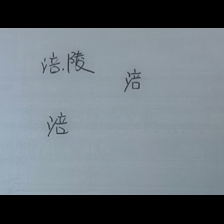

In [74]:

# file_path = f"./input/word.jpg"
# input_image = Image.open(file_path)
# word_imgs, word_info, bbox_img = extract_fullpage(input_image)
# bbox_img


# @title Word level Inference
file_path = 'input/1.jpg'
input_image = Image.open(file_path)

image, _, _, _, _ = scale_and_pad(input_image)

image

In [75]:


# @title Word-level inference
cf = model.signatures['serving_default']
input_text = tf.constant(["Recognize and derender."], dtype=tf.string)
image_encoded = tf.reshape(tf.io.encode_jpeg(np.array(image)[:, :, :3]), (1, 1))

In [76]:


output = cf(**{'input_text': input_text, 'image/encoded': image_encoded})


In [47]:
output

{'output_1': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>,
 'output_0': <tf.Tensor: shape=(1, 1), dtype=string, numpy=
 array([[b'<extra_id_0> Neat: <ink_token_450> <ink_token_1> <ink_token_290> <ink_token_450> <ink_token_50> <ink_token_319> <ink_token_50> <ink_token_320> <ink_token_50> <ink_token_321> <ink_token_50> <ink_token_323> <ink_token_50> <ink_token_326> <ink_token_50> <ink_token_329> <ink_token_50> <ink_token_333> <ink_token_50> <ink_token_337> <ink_token_50> <ink_token_342> <ink_token_49> <ink_token_347> <ink_token_49> <ink_token_352> <ink_token_48> <ink_token_357> <ink_token_47> <ink_token_361> <ink_token_47> <ink_token_365> <ink_token_46> <ink_token_367> <ink_token_46> <ink_token_368> <ink_token_46> <ink_token_367> <ink_token_450> <ink_token_50> <ink_token_330> <ink_token_51> <ink_token_330> <ink_token_52> <ink_token_331> <ink_token_54> <ink_token_333> <ink_token_56> <ink_token_335> <ink_token_58> <ink_token_338> <ink_token_61> <ink_token_34

In [73]:
decoded = output['output_0'].numpy()[0][0].decode()
text_to_tokens(decoded)

[450,
 1,
 290,
 450,
 50,
 319,
 50,
 320,
 50,
 321,
 50,
 323,
 50,
 326,
 50,
 329,
 50,
 333,
 50,
 337,
 50,
 342,
 49,
 347,
 49,
 352,
 48,
 357,
 47,
 361,
 47,
 365,
 46,
 367,
 46,
 368,
 46,
 367,
 450,
 50,
 330,
 51,
 330,
 52,
 331,
 54,
 333,
 56,
 335,
 58,
 338,
 61,
 341,
 64,
 345,
 67,
 348,
 70,
 352,
 73,
 355,
 75,
 358,
 77,
 360,
 78,
 361,
 79,
 361,
 450,
 79,
 320,
 79,
 321,
 79,
 323,
 79,
 326,
 79,
 329,
 79,
 333,
 79,
 337,
 80,
 342,
 80,
 346,
 80,
 350,
 81,
 354,
 81,
 357,
 81,
 360,
 81,
 362,
 82,
 363,
 83,
 363,
 450,
 94,
 350,
 95,
 351,
 96,
 351,
 98,
 351,
 100,
 351,
 102,
 350,
 105,
 349,
 108,
 348,
 110,
 346,
 112,
 345,
 113,
 343,
 113,
 342,
 112,
 341,
 111,
 341,
 109,
 341,
 106,
 342,
 103,
 343,
 100,
 345,
 98,
 348,
 96,
 351,
 95,
 354,
 95,
 357,
 96,
 360,
 98,
 362,
 100,
 363,
 103,
 364,
 106,
 364,
 109,
 363,
 112,
 362,
 115,
 360,
 450,
 140,
 344,
 139,
 343,
 138,
 342,
 136,
 341,
 134,
 341,
 132,
 341,
 130

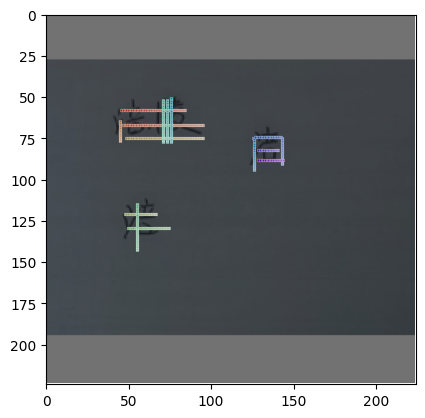

In [77]:

# @title Result Visualization
output_ink = detokenize(text_to_tokens(output['output_0'].numpy()[0][0].decode()))
fig, ax = plt.subplots()
plot_ink(output_ink, ax, input_image=load_and_pad_img(input_image))
plt.show()


In [37]:
!wget https://storage.googleapis.com/derendering_model/small-p-cpu.zip

--2024-11-13 09:32:04--  https://storage.googleapis.com/derendering_model/small-p-cpu.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.207, 142.251.31.207, 142.251.18.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 518277582 (494M) [application/zip]
Saving to: ‘small-p-cpu.zip’

small-p-cpu.zip     100%[===================>] 494.27M  27.3MB/s    in 17s     

2024-11-13 09:32:21 (29.2 MB/s) - ‘small-p-cpu.zip’ saved [518277582/518277582]



In [40]:
!wget https://storage.googleapis.com/derendering_model/small-p-tpu.zip

--2024-11-13 09:34:00--  https://storage.googleapis.com/derendering_model/small-p-tpu.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.207, 74.125.143.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519335341 (495M) [application/zip]
Saving to: ‘small-p-tpu.zip’

small-p-tpu.zip     100%[===================>] 495.28M  28.9MB/s    in 15s     

2024-11-13 09:34:15 (32.1 MB/s) - ‘small-p-tpu.zip’ saved [519335341/519335341]



In [42]:
!unzip -q small-p-cpu.zip

In [ ]:
# @title Result Visualization
output_inks = []
for b_id in range(len(output_batches)):
    for i in range(output_batches[b_id]['output_0'].shape[0]):
        output = output_batches[b_id]['output_0'].numpy()[i][0].decode()
        # fig, ax = plt.subplots()
        output_ink = detokenize(text_to_tokens(output))
        output_inks.append(output_ink)
        # plot_ink(output_ink, ax, input_image=Image.fromarray(original_word_imgs[b_id][i]))
        # plt.show()

all_inks = []
for ink, (ratio, dx, dy, min_x, min_y, angle) in zip(output_inks, word_info):
    recover_ink = unpad_unscale_unrotate_uncrop(ink, ratio, dx, dy, min_x, min_y, angle)
    all_inks.append(recover_ink)

lw=1.3
path_color='white'

fig, ax = plt.subplots(3, 1, figsize=(20, 10))
img = copy.deepcopy(input_image)
ax[0].imshow(input_image)
ax[0].set_title('Input Full page image')
ax[1].imshow(bbox_img)
ax[1].set_title("Tesseract")
ax[2].set_title("InkSight Result (Public Small-p)")

enhancer = ImageEnhance.Brightness(img)
img = copy.deepcopy(input_image)
img = enhancer.enhance(0.45)
ax[2].imshow(img)
for ink in all_inks:
    base_colors = plt.cm.get_cmap('rainbow', len(ink.strokes))
    for i, stroke in enumerate(ink.strokes):
        x, y = np.array(stroke.x), np.array(stroke.y)

        base_color = base_colors(len(ink.strokes) - 1 - i)
        hsv_color = colorsys.rgb_to_hsv(*base_color[:3])

        darker_color = colorsys.hsv_to_rgb(hsv_color[0], hsv_color[1], max(0, hsv_color[2] * 0.65))
        colors = [mcolors.to_rgba(darker_color, alpha=1 - (0.5 * j / len(x))) for j in range(len(x))]

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = LineCollection(segments, colors=colors, linewidth=lw)
        lc_two = LineCollection(segments, colors=colors, linewidth=lw)
        lc.set_path_effects([withStroke(linewidth=lw*1.25, foreground=path_color)])
        lc_two.set_path_effects([withStroke(linewidth=lw*1.8)])
        ax[2].add_collection(lc)
        ax[1].add_collection(lc_two)